In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from coffea import util
import matplotlib.pyplot as plt
from pltStyle import pltStyle
import mplhep as hep
pltStyle(style='hep')

In [4]:
# outname = '../out/CoffeaJERCOutputs_L5_QCD-MG-Py_alphacut_0p2.coffea'
# output = util.load(outname)

In [5]:
def get_output(data_tag):
    ''' Load response histogram data with the tag `data_tag`
    '''
    tag_full = '_L5'+data_tag
    outname = '../out/CoffeaJERCOutputs'+tag_full+'.coffea'
    output = util.load(outname)
    return output

In [6]:
def get_file_dict(data_tag):
    ''' Load a text file with cross sections and file names as a dictionary `file_dict`.
    '''
    if "_QCD-MG" in data_tag:
        if '_DY-MG-Her' in data_tag:
            dataset_list_file = '../fileNames/QCD_Herwig_20UL18/xsecs_QCD_Herwig_corrected.txt'
        else:
            dataset_list_file = '../fileNames/QCD_MG_Py8_20UL18/xsecs_QCD_MG_py8.txt'
        with open(dataset_list_file) as f:
            lines = f.readlines()
        lines_split = [line.split() for line in lines]
        file_dict = {data_tag[1:]+'_'+lineii[1]: xsecstr2float(lineii[2]) for lineii in lines_split }
    else:
        file_dict = 1
    return file_dict

In [7]:
# output_orig = output
def sum_output(output, data_tag, file_dict):
    ''' If the file with histograms `output` contains a dictionary over many datasets (e.g. different pt ranges),
    sum them up proportionally to the cross sections in `file_dict` 
    Output: summed up hisograms `output`
    '''
    if "_QCD-MG" in data_tag:
        response_sums = {key:sum(dictionary_pattern(output[key], "ptresponse_").values()).sum().value for key in output.keys()}
        scale_factors = hist_div(file_dict, response_sums)
        all_histo_keys = output[next(iter(output.keys()))].keys()
        result = {histo_key:sum_subhist(output, histo_key, scale_factors) for histo_key in all_histo_keys }
        output = result
    elif len(output.keys())==1:
        output = output[list(output.keys())[0]]
    return output

In [8]:
import sys
import os
top_path = '..'
if top_path not in sys.path:
    sys.path.append(top_path)
from helpers import xsecstr2float, dictionary_pattern, hist_div, sum_subhist

In [39]:
# data_tag = '_QCD-MG-Py'
data_tag = '_QCD-MG-Py'
add_tag = ''
# add_tag = '_leading_jets'
tag_full=data_tag+add_tag
output = get_output(tag_full)
file_dict = get_file_dict(data_tag)
output = sum_output(output, data_tag+add_tag, file_dict)
# tag_full = 'QCD-MG-Py_alphacut_0p2_promptlep_gen15'
# outname = '../out/CoffeaJERCOutputs_L5_QCD-MG-Py_alphacut_0p2_promptlep_gen15.coffea'
# output = util.load(outname)

In [40]:
output.keys()

dict_keys(['ptresponse_b', 'ptresponse_c', 'ptresponse_s', 'ptresponse_u', 'ptresponse_d', 'ptresponse_bbar', 'ptresponse_cbar', 'ptresponse_sbar', 'ptresponse_ubar', 'ptresponse_dbar', 'ptresponse_g', 'ptresponse_unmatched', 'reco_pt_sumwx_b', 'reco_pt_sumwx_c', 'reco_pt_sumwx_s', 'reco_pt_sumwx_u', 'reco_pt_sumwx_d', 'reco_pt_sumwx_bbar', 'reco_pt_sumwx_cbar', 'reco_pt_sumwx_sbar', 'reco_pt_sumwx_ubar', 'reco_pt_sumwx_dbar', 'reco_pt_sumwx_g', 'reco_pt_sumwx_unmatched', 'cutflow'])

In [41]:
# cutflow = output['QCD-MG-Py_HT50to100']['cutflow']
cutflow = output['cutflow']

In [46]:
cutflow
cutflow.axes[0]

Hist(StrCategory(['all_events', 'selected_events', 'all_jets', 'gen_matched+no_dressed_lep', 'jetpt>15', 'iso jets'], growth=True, name='cutflow', label='Cutflow Scenarios'), storage=Weight()) # Sum: WeightedSum(value=5.06334e+09, variance=2.27822e+15)

StrCategory(['all_events', 'selected_events', 'all_jets', 'gen_matched+no_dressed_lep', 'jetpt>15', 'iso jets'], growth=True, name='cutflow', label='Cutflow Scenarios')

In [13]:
plt.rcParams['figure.subplot.bottom'] = 0.37

In [14]:
def remove_xminor_ticks():
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

In [47]:
alpha_keys = [key for key in cutflow.axes[0] if 'alpha' in key ][0:2]

In [48]:
figdir = "fig/cutflow"
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [57]:
def cutflow_event_plot(cutflow, tag_full, title_name):
    events_cutflow = cutflow[['all_events', 'selected_events']] #, alpha_keys[1]]]
    fig, ax = plt.subplots()
    mc = next(ax._get_lines.prop_cycler)
    events_cutflow.plot1d(color=mc['color'])
    ax.set_ylabel('N events')
    # ax.minorticks_off()
    remove_xminor_ticks()
    plt.xticks(rotation=60)
    hep.label.exp_text(text=title_name, loc=0)

    fig_name = figdir+"/cutflow_Nevents_"+tag_full
    print("Saving plot with the name = ", fig_name)
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');
    plt.show()
    

def cutflow_jet_plot(cutflow, tag_full, title_name):
    jets_cutflow = cutflow[['all_jets', 'gen_matched+no_dressed_lep',
                                 'jetpt>15', 'iso jets']]
    mylabs = ['all jets', 'gen matched+ \n no dressed lep',
              '$p_{T,Gen}>15$ GeV', 'iso jets']
#     jets_cutflow = cutflow[['all_jets', 'gen_matched','no_dressed_lep',
#                                  'jetpt>15', alpha_keys[0], 'iso jets']]
#     mylabs = ['all jets', 'gen matched', 'no dressed lep',
#               '$p_{T,Gen}>15$ GeV', r'$\alpha<1.0$'+'\nleading jets', 'iso jets']
    fig, ax = plt.subplots()
    jets_cutflow.plot1d()
    ax.set_ylabel('N jets')
    remove_xminor_ticks()
    xticklab = ax.get_xticklabels()
    plt.xticks(rotation=60)
    for lab, lab_txt in zip(xticklab, mylabs):
        lab.set_text(lab_txt)
    ax.set_xticklabels(xticklab)
    hep.label.exp_text(text=title_name, loc=0)

    fig_name = figdir+"/cutflow_Njets_"+tag_full
    print("Saving plot with the name = ", fig_name)
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');
    plt.show()
    
def cutflow_events_jet_plot(cutflow, tag_full, title_name):
    jets_cutflow = cutflow[['all_jets', 'gen_matched+no_dressed_lep',
                                 'jetpt>15', 'iso jets']]
    mylabs = ['all jets', 'gen matched+ \n no dressed lep',
              '$p_{T,Gen}>15$ GeV', 'iso jets']
#     jets_cutflow = (cutflow[['all_jets', 'gen_matched','no_dressed_lep',
#                              'jetpt>15', alpha_keys[0], 'iso jets']]
#                     /cutflow['all_events'].value )
#     mylabs = ['all jets', 'gen matched', 'no dressed lep', 
#               '$p_{T,Gen}>15$ GeV', r'$\alpha<1.0$'+'\nleading jets', 'iso jets']

    fig, ax = plt.subplots()
    jets_cutflow.plot1d()
    ax.set_ylabel('N jets/ N events')
    remove_xminor_ticks()

    xticklab = ax.get_xticklabels()
    plt.xticks(rotation=60)
    for lab, lab_txt in zip(xticklab, mylabs):
        lab.set_text(lab_txt)
    ax.set_xticklabels(xticklab)
    hep.label.exp_text(text=title_name, loc=0)

    fig_name = figdir+"/cutflow_Njets_per_ev_"+tag_full
    print("Saving plot with the name = ", fig_name)
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');
    plt.show()
    
def cutflow_events_jet_plot_last(cutflow, tag_full, title_name):
    jets_cutflow = cutflow[['all_jets', 'gen_matched+no_dressed_lep',
                                 'jetpt>15', 'iso jets']]
    mylabs = ['all jets', 'gen matched+ \n no dressed lep',
              '$p_{T,Gen}>15$ GeV', 'iso jets']
#     jets_cutflow = (cutflow[['jetpt>15', alpha_keys[0], 'iso jets']]
#                     /cutflow['all_events'].value )
#     mylabs = ['$p_{T,Gen}>15$ GeV', r'$\alpha<1.0$'+'\nleading jets', 'iso jets']

    fig, ax = plt.subplots()
    jets_cutflow.plot1d() #label=r'blah, \n 2')
    ax.set_ylabel('N jets/ N events')
    remove_xminor_ticks()

    xticklab = ax.get_xticklabels()
    plt.xticks(rotation=60)
    for lab, lab_txt in zip(xticklab, mylabs):
        lab.set_text(lab_txt)
    ax.set_xticklabels(xticklab)
    hep.label.exp_text(text=title_name, loc=0)
    
    fig_name = figdir+"/cutflow_Njets_per_ev_"+tag_full
    print("Saving plot with the name = ", fig_name)
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');
    plt.show()

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Nevents_QCD-MG-Py_HT1500to2000


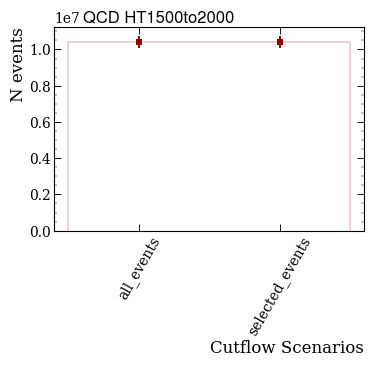

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Njets_QCD-MG-Py_HT1500to2000


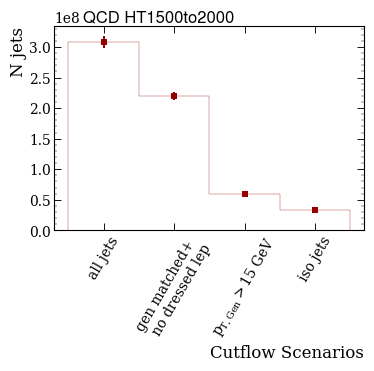

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Njets_per_ev_QCD-MG-Py_HT1500to2000


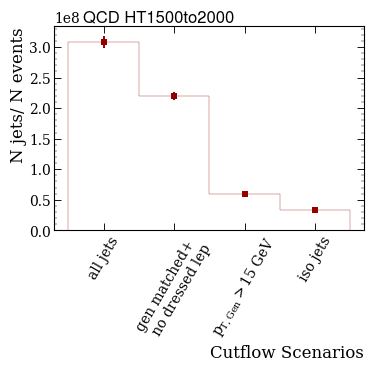

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Njets_per_ev_QCD-MG-Py_HT1500to2000


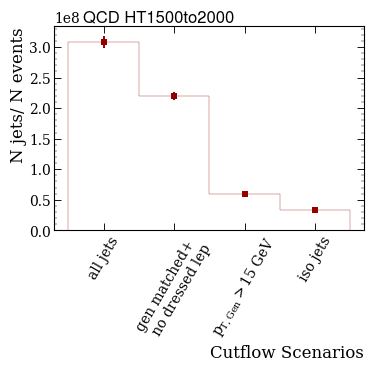

In [58]:
tag_full = 'QCD-MG-Py_HT1500to2000' #_leading_jets
title_name = 'QCD HT1500to2000'
outname = '../out/CoffeaJERCOutputs_L5_QCD-MG-Py.coffea'
output = util.load(outname)
cutflow = output['QCD-MG-Py_HT1500to2000']['cutflow']
cutflow_event_plot(cutflow, tag_full, title_name)
cutflow_jet_plot(cutflow, tag_full, title_name)
cutflow_events_jet_plot(cutflow, tag_full, title_name)
cutflow_events_jet_plot_last(cutflow, tag_full, title_name)

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Nevents__QCD-MG-Py


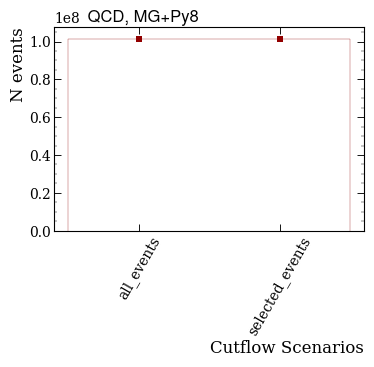

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Njets__QCD-MG-Py


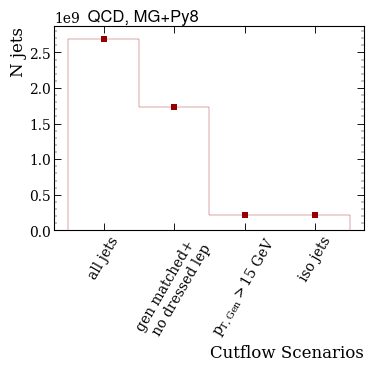

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Njets_per_ev__QCD-MG-Py


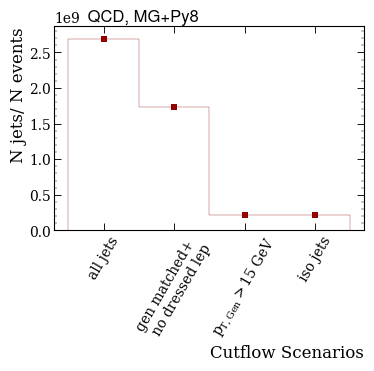

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Njets_per_ev__QCD-MG-Py


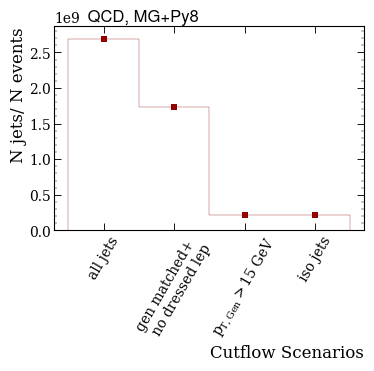

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Nevents__QCD-MG-Her


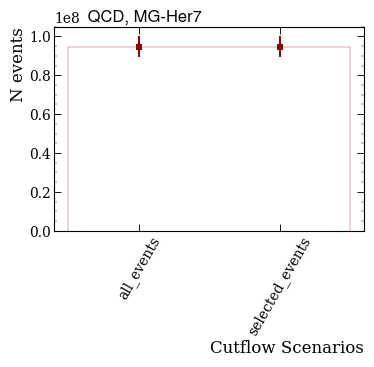

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Njets__QCD-MG-Her


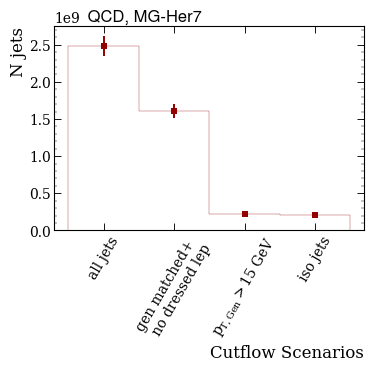

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Njets_per_ev__QCD-MG-Her


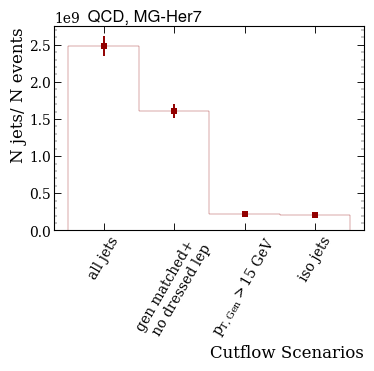

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Njets_per_ev__QCD-MG-Her


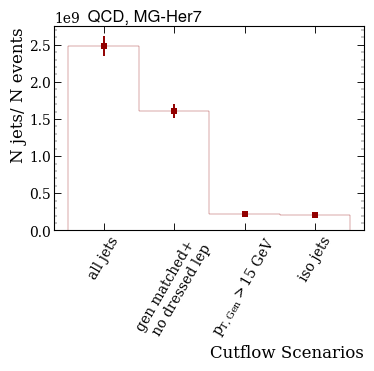

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Nevents__DY-MG-Py


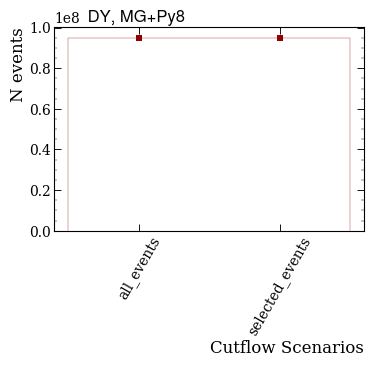

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Njets__DY-MG-Py


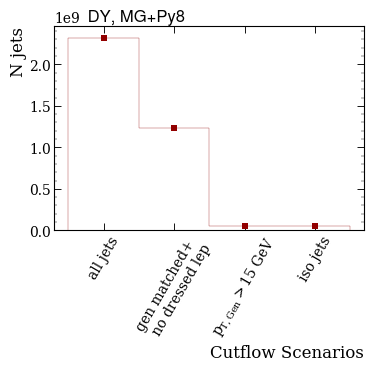

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Njets_per_ev__DY-MG-Py


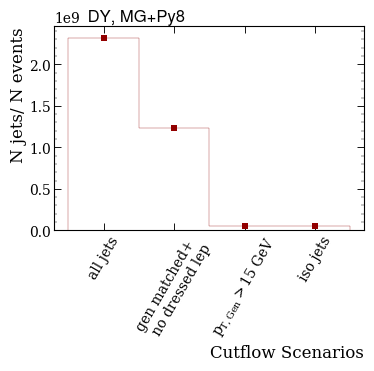

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Njets_per_ev__DY-MG-Py


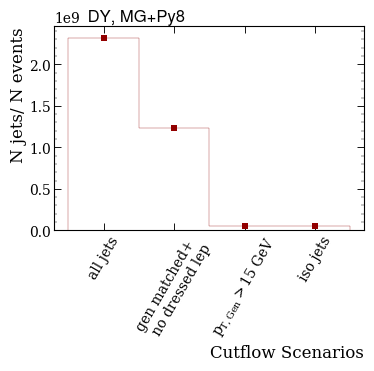

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Nevents__DY-MG-Her


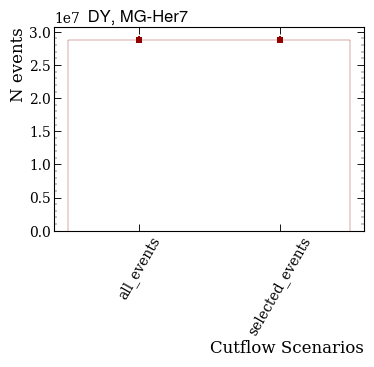

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Njets__DY-MG-Her


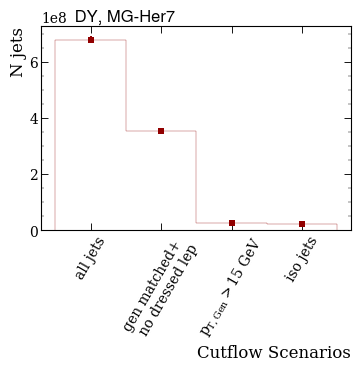

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Njets_per_ev__DY-MG-Her


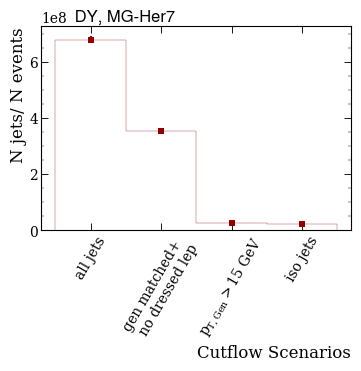

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Saving plot with the name =  fig/cutflow/cutflow_Njets_per_ev__DY-MG-Her


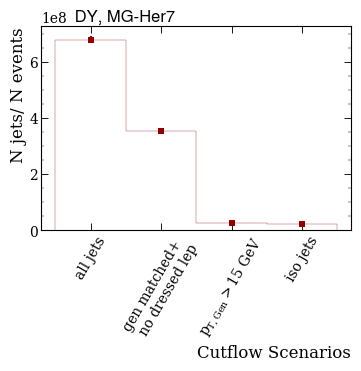

In [59]:
data_tags = ['_QCD-MG-Py', '_QCD-MG-Her', '_DY-MG-Py', '_DY-MG-Her']
title_names = [' QCD, MG+Py8', ' QCD, MG-Her7', ' DY, MG+Py8', ' DY, MG-Her7']
for data_tag, title_name in zip(data_tags, title_names):
#     data_tag = '_QCD-MG-Py'
    add_tag = ''
    tag_full=data_tag+add_tag
    output = get_output(tag_full)
    file_dict = get_file_dict(data_tag)
    output = sum_output(output, data_tag+add_tag, file_dict)
    
    cutflow = output['cutflow']
    cutflow_event_plot(cutflow, tag_full, title_name)
    cutflow_jet_plot(cutflow, tag_full, title_name)
    cutflow_events_jet_plot(cutflow, tag_full, title_name)
    cutflow_events_jet_plot_last(cutflow, tag_full, title_name)

In [19]:
# xticklab = ax.get_xticklabels() '$alpha<0.2$+leading jets'


In [71]:


# jets_cutflow = cutflow[['all_jets', 'gen_matched+no_dressed_lep',
#                                                          'jetpt>15', 'alpha<0.2; leading jets', 'iso jets']]
# fig, ax = plt.subplots()
# jets_cutflow.plot1d()
# ax.set_ylabel('N jets')
# ax.minorticks_off()
# plt.xticks(rotation=60)
# ax.set_xticklabels(xticklab)
1;

In [19]:
# cutflow

In [20]:
# cutflow['alpha<0.2; leading jets']
# cutflow['no_dressed_lep']

In [72]:
# jets_cutflow = (cutflow[['all_jets', 'gen_matched','no_dressed_lep',
#                          'jetpt>15', 'alpha<1.0; leading jets', 'iso jets']]
#                 /cutflow['all_events'].value )
# mylabs = ['all jets', 'gen matched', 'no dressed lep', '$p_{T,Gen}>15$ GeV', r'$\alpha<1.0$'+'\nleading jets', 'iso jets']

# fig, ax = plt.subplots()
# jets_cutflow.plot1d()
# ax.set_ylabel('N jets/ N events')
# remove_xminor_ticks()

# xticklab = ax.get_xticklabels()
# plt.xticks(rotation=60)
# for lab, lab_txt in zip(xticklab, mylabs):
#     lab.set_text(lab_txt)
# ax.set_xticklabels(xticklab)

# fig_name = figdir+"/cutflow_Njets_per_ev_"+tag_full
# print("Saving plot with the name = ", fig_name)
# plt.savefig(fig_name+'.pdf');
# plt.savefig(fig_name+'.png');

# jets_cutflow = (output['QCD-MG-Py_HT50to100']['cutflow'][['all_jets', 'gen_matched+no_dressed_lep',
#                                                          'jetpt>15', 'alpha<0.2; leading jets', 'iso jets']]
#                 /output['QCD-MG-Py_HT50to100']['cutflow']['all_events'].value )
# fig, ax = plt.subplots()
# jets_cutflow.plot1d()
# ax.set_ylabel('N jets/ N events')
# ax.minorticks_off()
# plt.xticks(rotation=60)
# ax.set_xticklabels(xticklab)
1;

In [73]:
# jets_cutflow = (cutflow[['jetpt>15', 'alpha<1.0; leading jets', 'iso jets']]
#                 /cutflow['all_events'].value )
# mylabs = ['$p_{T,Gen}>15$ GeV', r'$\alpha<1.0$'+'\nleading jets', 'iso jets']

# fig, ax = plt.subplots()
# jets_cutflow.plot1d()
# ax.set_ylabel('N jets/ N events')
# remove_xminor_ticks()

# xticklab = ax.get_xticklabels()
# plt.xticks(rotation=60)
# for lab, lab_txt in zip(xticklab, mylabs):
#     lab.set_text(lab_txt)
# ax.set_xticklabels(xticklab)

# fig_name = figdir+"/cutflow_Njets_per_ev_"+tag_full
# print("Saving plot with the name = ", fig_name)
# plt.savefig(fig_name+'.pdf');
# plt.savefig(fig_name+'.png');

# # jets_cutflow = (output['QCD-MG-Py_HT50to100']['cutflow'][['all_jets', 'gen_matched+no_dressed_lep',
# #                                                          'jetpt>15', 'alpha<0.2; leading jets', 'iso jets']]
# #                 /output['QCD-MG-Py_HT50to100']['cutflow']['all_events'].value )
# # fig, ax = plt.subplots()
# # jets_cutflow.plot1d()
# # ax.set_ylabel('N jets/ N events')
# # ax.minorticks_off()
# # plt.xticks(rotation=60)
# # ax.set_xticklabels(xticklab)
# 1;

In [74]:
# jets_cutflow = (cutflow[['all_jets', 'gen_matched+no_dressed_lep',
#                                                          'jetpt>15', 'alpha<0.2; leading jets', 'iso jets']]
#                 /cutflow['all_events'].value )
# fig, ax = plt.subplots()
# jets_cutflow.plot1d()
# ax.set_ylabel('N jets/ N events')
# remove_xminor_ticks()

# xticklab = ax.get_xticklabels()
# plt.xticks(rotation=60)
# for lab, lab_txt in zip(xticklab, mylabs):
#     lab.set_text(lab_txt)
# ax.set_xticklabels(xticklab)

# fig_name = figdir+"/cutflow_Njets_per_ev_"+tag_full
# print("Saving plot with the name = ", fig_name)
# plt.savefig(fig_name+'.pdf');
# plt.savefig(fig_name+'.png');

# # jets_cutflow = (output['QCD-MG-Py_HT50to100']['cutflow'][['all_jets', 'gen_matched+no_dressed_lep',
# #                                                          'jetpt>15', 'alpha<0.2; leading jets', 'iso jets']]
# #                 /output['QCD-MG-Py_HT50to100']['cutflow']['all_events'].value )
# # fig, ax = plt.subplots()
# # jets_cutflow.plot1d()
# # ax.set_ylabel('N jets/ N events')
# # ax.minorticks_off()
# # plt.xticks(rotation=60)
# # ax.set_xticklabels(xticklab)
# 1;

In [202]:
# jets_cutflow.plot1d()
